In [144]:
# !pip install ucimlrepo

from ucimlrepo import fetch_ucirepo 
import sklearn.metrics
import math
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


# fetch dataset 
wine = fetch_ucirepo(id=109) 
  
# data (as pandas dataframes) 
X = wine.data.features 
y = wine.data.targets 
  
# metadata 
# print(wine.metadata) 
  
# variable information 
wine.variables

,name,role,type,demographic,description,units,missing_values
0,class,Target,Categorical,None,None,None,no
1,Alcohol,Feature,Continuous,None,None,None,no
2,Malicacid,Feature,Continuous,None,None,None,no
3,Ash,Feature,Continuous,None,None,None,no
4,Alcalinity_of_ash,Feature,Continuous,None,None,None,no
5,Magnesium,Feature,Integer,None,None,None,no
6,Total_phenols,Feature,Continuous,None,None,None,no
7,Flavanoids,Feature,Continuous,None,None,None,no
8,Nonflavanoid_phenols,Feature,Continuous,None,None,None,no
9,Proanthocyanins,Feature,Continuous,None,None,None,no


In [112]:
features_used =  np.array([0,1])
use_all_features = True

classes_used = np.array([1,2])
use_all_classes = True

ninit = 5
addn = 1

X_used = X.to_numpy()
y_used = y.to_numpy().reshape(-1)

if not use_all_features:
    X_used = X.to_numpy()[ : , features_used]   

if not use_all_classes:
    mask = np.isin(y_used, classes_used)
    y_used = y_used[mask]
    X_used = X_used[mask]

Xpool, Xtest, ypool, ytest = train_test_split(
    X_used, y_used, 
    train_size=100, 
    stratify=y_used, 
    random_state=42  # optional for reproducibility
)

order=np.random.permutation(range(len(Xpool)))


In [145]:
def norm_grad_x(theta,x, C=1.):
    # probability of high class
    # if len(x) > 40:
    #   print(theta*x)
    
    p1 = 1/(1+np.exp(-np.sum(theta*x)))
      # probability of low class
    p0 = 1-p1
      # derivative of cost as derived above for high class
    dL1=-x/(1+np.exp(theta*x))+theta/C
      # same for low class
    dL0=x*np.exp(theta*x)/(1+np.exp(theta*x))+theta/C
      # 2-norm of these
    g1=np.sqrt(np.sum(dL1**2,1))
    g0=np.sqrt(np.sum(dL0**2,1))
      # averaged according to probabilities
    emc=p1*g1+p0*g0
    return emc

def norm_grad_softmax(theta, x, C=1.0):
    """
    Expected gradient norm for softmax cross-entropy loss.

    Args:
        theta: (K, D) weight matrix from LogisticRegression (multiclass)
        x: (N, D) input samples
        C: regularization parameter

    Returns:
        emc: (N,) array with expected gradient norm per sample
    """
    K, D = theta.shape
    N = x.shape[0]

    # Compute logits and softmax probabilities
    logits = x @ theta.T  # shape: (N, K)
    logits -= np.max(logits, axis=1, keepdims=True)  # for numerical stability
    exp_logits = np.exp(logits)
    probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)  # shape: (N, K)

    # Initialize EMC values
    emc = np.zeros(N)

    for k in range(K):
        # Assume true label is class k → one-hot y
        yk = np.zeros_like(probs)
        yk[:, k] = 1.0

        # Gradient: (p_k - y_k) * x
        diff = probs - yk  # shape: (N, K)
        grad = diff[:, :, np.newaxis] * x[:, np.newaxis, :]  # shape: (N, K, D)

        # Add L2 regularization gradient
        grad += theta[np.newaxis, :, :] / C  # broadcast to (N, K, D)

        # Compute 2-norm of the gradient per sample
        grad_norms = np.linalg.norm(grad, axis=(1, 2))  # shape: (N,)
        emc += probs[:, k] * grad_norms  # weighted by probability

    return emc

def evaluate_uncertainty(prob, strategy):
    """Evaluate the desired uncertainty sampling strategy on predictive
    probabilities 'prob'.

    PARAMETERS
    ----------
    prob : ndarray 
        numpy array with predictive probabilities of shape 
        (n_points, n_classes)
    strategy : str
        One of 'least confident', 'margin', or 'entropy'.

    The function should return an array with uncertainties of shape
    (n_points, ) corresponding to the desired strategy.
    """
    # solution::start
    if strategy == 'least confident':
        res = 1 - prob.max(1)
    elif strategy == 'margin':
        ix = np.arange(len(prob))
        p2, p1 = prob.argsort(1)[:, -2:].T
        res = 1 - (prob[ix, p1] - prob[ix, p2])
    elif strategy == 'entropy':
        res = - np.sum(prob * np.log2(prob), axis=1)
    else:
        raise ValueError
    return res
    # solution::end

In [156]:
def prepare_data(X, y, n_init, use_classes=None, use_features=None, seed=None):
    from sklearn.model_selection import StratifiedShuffleSplit
    """Extract classes and features and split data into training, pool, and test sets."""
    
    X = X  # Ensure NumPy format
    y = y.ravel()  # Flatten target values to 1D

    # Filter classes if needed
    if use_classes is not None:
        use_examples = np.isin(y, use_classes)
        X = X[use_examples]
        y = y[use_examples]

    # Select features if specified
    if use_features is not None:
        X = X[:, use_features]

    n = len(X)
    assert n_init <= n

    # Split into train, pool, and test using stratified sampling
    sss = StratifiedShuffleSplit(n_splits=1, train_size=n_init / n, random_state=seed)
    train_idx, pool_idx = next(sss.split(X, y))

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    pool_idx_, test_idx = next(sss.split(X[pool_idx], y[pool_idx]))

    return dict(
        train=dict(X=X[train_idx], y=y[train_idx]),
        pool=dict(X=X[pool_idx[pool_idx_]], y=y[pool_idx[pool_idx_]]),
        test=dict(X=X[pool_idx[test_idx]], y=y[pool_idx[test_idx]])
    )

def update_data(data, idx):
    """Move a data point from the pool to the training set."""
    data['train']['X'] = np.append(data['train']['X'], np.atleast_2d(data['pool']['X'][idx]), axis=0)
    data['train']['y'] = np.append(data['train']['y'], np.atleast_1d(data['pool']['y'][idx]).ravel(), axis=0)  # Ensure 1D
    data['pool']['X'] = np.delete(data['pool']['X'], idx, axis=0)
    data['pool']['y'] = np.delete(data['pool']['y'], idx, axis=0)


In [166]:
def fit_model(X, y, paradigm, strategy, n_init, n_iterations, use_classes=None, use_features=None, plot=False):
    """Run `n_iterations` of active learning or random sampling.
    
    PARAMETERS
    ----------
    X, y : DataFrame, Series
        Feature matrix and target values.
    paradigm : str
        One of 'active learning' or 'random'.
    strategy : str
        The uncertainty strategy to use (only used when paradigm = 'active learning').
    n_init : int
        The initial number of points in the training set.
    n_iterations : int
        The number of iterations to run.
    use_classes, use_features (same as for prepare_data)
    plot : bool
        Whether to visualize the sampling process.

    RETURNS
    ----------
    scores : ndarray
        The accuracy score at each iteration.    
    """
    # Prepare the dataset
    data = prepare_data(X, y, n_init, use_classes, use_features)
    scores = np.zeros(n_iterations)

    # Initialize model
    model = LogisticRegression(penalty='l2', C=1e1, solver='liblinear', warm_start=True)

    for i in range(n_iterations):
        # 1. Fit the model
        model.fit(data['train']['X'], data['train']['y'])

        # 2. Evaluate on pool
        prob = model.predict_proba(data['pool']['X'])
        scores[i] = model.score(data['test']['X'], data['test']['y'])

        # 3. Select sample based on uncertainty (or random selection)            
        if paradigm == 'active learning':
            
            if strategy != "gradient":
                uncertainty = evaluate_uncertainty(prob, strategy)
            
            if strategy in ('least confident', 'entropy'):
                idx = uncertainty.argmax()
            elif strategy == 'margin':
                idx = uncertainty.argmax()
            elif strategy == "gradient":
                uncertainty = None
                num_classes = np.unique(data['train']['y']).size
                if num_classes == 2:
                    emc=norm_grad_x(model.coef_, data['pool']['X'])
                elif num_classes > 2:
                    emc=norm_grad_softmax(model.coef_, data['pool']['X'])
                else:
                    raise ValueError("Invalid num classes")
                idx = emc.argmax()
            else:
                raise ValueError(f"Unknown strategy: {strategy}")
        elif paradigm == 'random':
            uncertainty = None
            idx = np.random.choice(len(data['pool']['X']))
        
    
        else:
            raise ValueError(f"Unknown paradigm: {paradigm}")

        # 4. Update training set and pool
        update_data(data, idx)

        # 5. Plot if requested
        if plot:
            plot_pool(data, idx, uncertainty)

    return scores

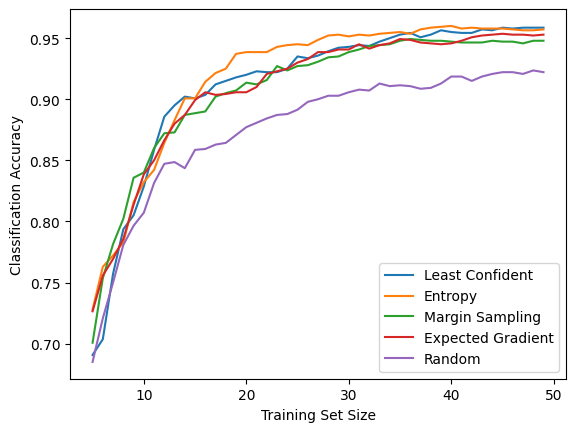

In [168]:
# Settings
n_init = 5
n_iterations = 50 - n_init
n_avg = 40

# Run experiments
scores_least = np.zeros((n_avg, n_iterations))
scores_entropy = np.zeros((n_avg, n_iterations))
scores_margin = np.zeros((n_avg, n_iterations))

scores_rn = np.zeros((n_avg, n_iterations))

scores_gradient = np.zeros((n_avg, n_iterations))

for i in range(n_avg):
    scores_least[i] = fit_model(X, y, 'active learning', 'least confident', n_init, n_iterations)
    scores_entropy[i] = fit_model(X, y, 'active learning', 'entropy', n_init, n_iterations)
    scores_margin[i] = fit_model(X, y, 'active learning', 'margin', n_init, n_iterations)

    scores_rn[i] = fit_model(X, y, 'random', 'least confident', n_init, n_iterations)
    scores_gradient[i] = fit_model(X,y, 'active learning', 'gradient', n_init, n_iterations)

# Plot the results
fig, ax = plt.subplots()
ax.plot(np.arange(n_init, n_iterations + n_init), scores_least.mean(0), label='Least Confident')
ax.plot(np.arange(n_init, n_iterations + n_init), scores_entropy.mean(0), label='Entropy')
ax.plot(np.arange(n_init, n_iterations + n_init), scores_margin.mean(0), label='Margin Sampling')
ax.plot(np.arange(n_init, n_iterations + n_init), scores_gradient.mean(0), label='Expected Gradient')
ax.plot(np.arange(n_init, n_iterations + n_init), scores_rn.mean(0), label='Random')
ax.legend()
ax.set_xlabel('Training Set Size')
ax.set_ylabel('Classification Accuracy')
plt.show()

In [ ]:
# reset training set and pool
testacc_emc=[]
trainset=order[:ninit]
Xtrain=np.take(Xpool,trainset,axis=0)
ytrain=np.take(ypool,trainset,axis=0)
poolidx=np.arange(len(Xpool),dtype=np.int64)
poolidx=np.setdiff1d(poolidx,trainset)

model = LogisticRegression(penalty='l2', C=1e1, solver='liblinear')

for i in range(math.ceil((len(Xpool) - ninit) / addn)):
    model.fit(Xtrain, ytrain)
    if not use_all_classes and len(classes_used) == 2:
        emc=norm_grad_x(model.coef_, Xpool[poolidx])
    elif use_all_classes:
        emc=norm_grad_softmax(model.coef_, Xpool[poolidx])
    else:
        raise ValueError
    
    ye=model.predict(Xtest)
    testacc_emc.append((len(Xtrain),sklearn.metrics.accuracy_score(ytest,ye)))

    ypool_p_sort_idx = np.argsort(emc)
    Xtrain=np.concatenate((Xtrain,Xpool[poolidx[ypool_p_sort_idx[-addn:]]]))
    ytrain=np.concatenate((ytrain,ypool[poolidx[ypool_p_sort_idx[-addn:]]]))
    poolidx=np.setdiff1d(poolidx,poolidx[ypool_p_sort_idx[-addn:]])
    # print('Model: LR, %i samples (EMC)'%(ninit+i*addn))
    
trainset=order[:ninit]
Xtrain=np.take(Xpool,trainset,axis=0)
ytrain=np.take(ypool,trainset,axis=0)
poolidx=np.arange(len(Xpool),dtype=np.int64)
poolidx=np.setdiff1d(poolidx,trainset)

testacc=[]
for i in range(math.ceil((len(Xpool) - ninit) / addn)):
    #TODO fit model
    #Hints below:
    #data:np.take(Xpool,order[:ninit+i*addn],axis=0)
    #labels: np.take(ypool,order[:ninit+i*addn],axis=0)
    data = np.take(Xpool, order[:ninit + i*addn], axis=0)
    labels = np.take(ypool, order[:ninit + i*addn], axis=0)
    model.fit(data, labels)
    #predict and calculate the accuracy
    y_pred = model.predict(Xtest)
    accuracy = np.sum(y_pred == ytest) / len(ytest)
    #calculate accuracy on test set
    testacc.append((ninit+i*addn, accuracy)) #add in the accuracy
    # print('Model: LR, %i random samples'%(ninit+i*addn))

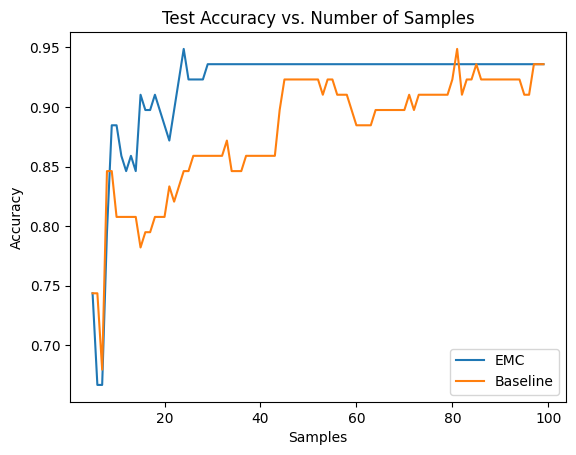

In [115]:
cut_at = 1000

plt.plot(*tuple(np.array(testacc_emc[:cut_at]).T), label='EMC')
plt.plot(*tuple(np.array(testacc[:cut_at]).T), label='Baseline')

plt.legend()  # Show the legend
plt.xlabel("Samples")
plt.ylabel("Accuracy")
plt.title("Test Accuracy vs. Number of Samples")
plt.show()